## Purpose: Analyze efficacy of alt data sources in predicting real estate index price (avg home value)

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from utils.global_functions import df_colors, get_local_psql_conn
from utils.visualizations import df_colors, plot_all_time_series
from utils import visualizations as plots

import warnings

warnings.filterwarnings("ignore")
plt.style.use("dark_background")
pd.set_option("display.float_format", lambda x: "%.3f" % x)

from utils import analysis

In [63]:
df_all_monthly = pd.read_csv('s3://general-scratch/alt_data/monthly_aggregated_alt_data.csv', date_format='%Y-%m-%d', infer_datetime_format=True, index_col=0)
data = df_all_monthly.copy()
df = data.copy()
df_all_monthly

,avg_sales,sales_count,target_ci,target_citi,target_op,target_ev,target_hi
yr-month,,,,,,,
2014-11-01,615062.529412,221.117647,406.235294,88200.833333,25.846154,181.667782,10.115088
2014-12-01,625818.588235,263.000000,405.294118,66513.833333,27.071429,177.767886,10.437336
2015-01-01,653781.941176,213.588235,382.411765,47592.833333,25.769231,165.677297,11.389263
2015-02-01,626591.117647,218.705882,365.352941,32821.833333,28.000000,179.166666,10.380905
2015-03-01,661066.470588,238.411765,456.058824,56969.166667,31.125000,161.776812,11.673807
...,...,...,...,...,...,...,...
2022-12-01,937305.058824,217.764706,1044.823529,234896.142857,15.461538,33.375000,23.569686
2023-01-01,902709.764706,179.176471,1235.058824,231250.250000,16.076923,80.500000,26.776744
2023-02-01,869542.058824,158.882353,1048.294118,218318.500000,16.454545,50.500000,25.774340


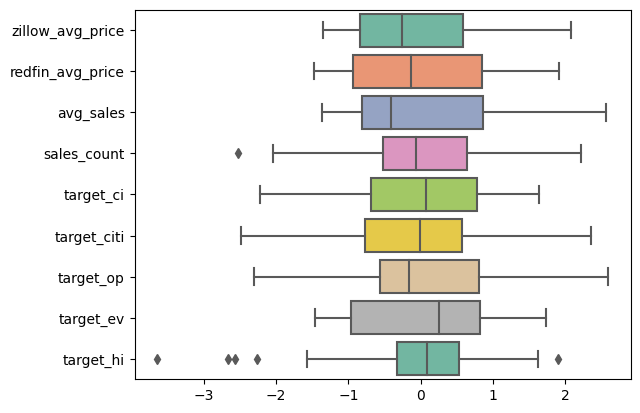

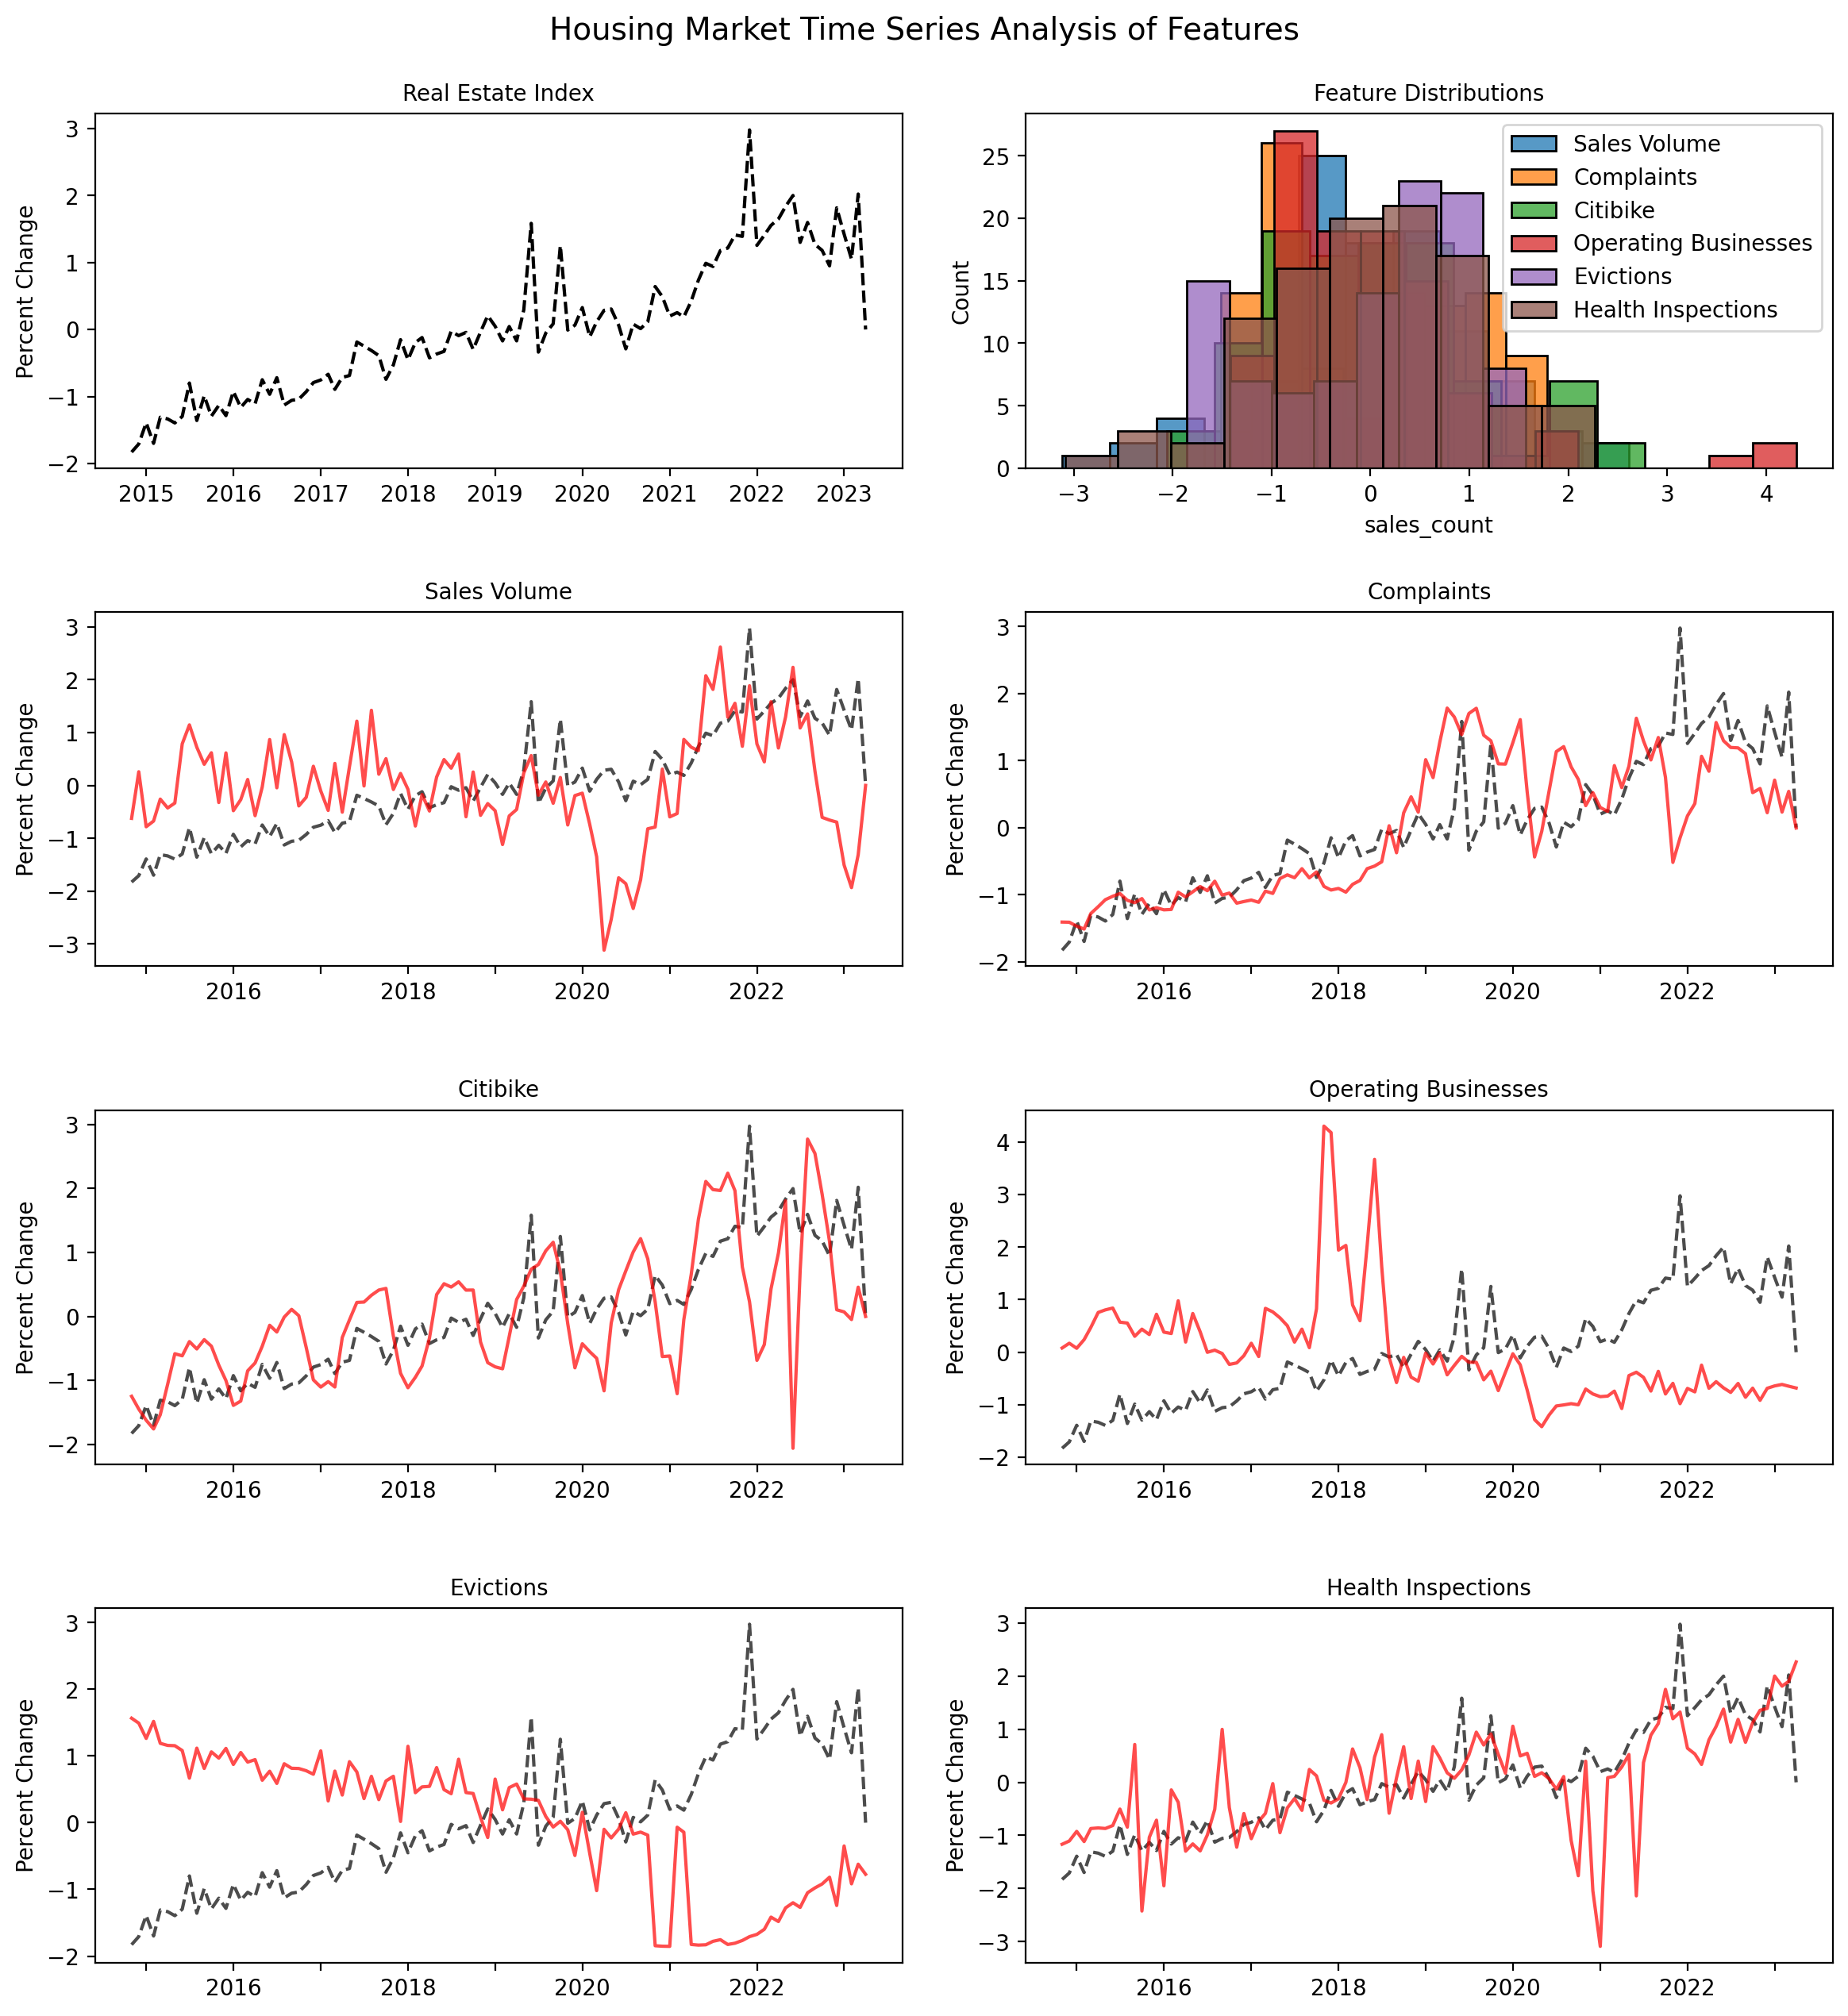

In [64]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plot data
with    plt.style.context('default'):
    plots.plot_all_time_series(df_all_monthly, "Housing Market Time Series Analysis of Features", for_ieee=True)

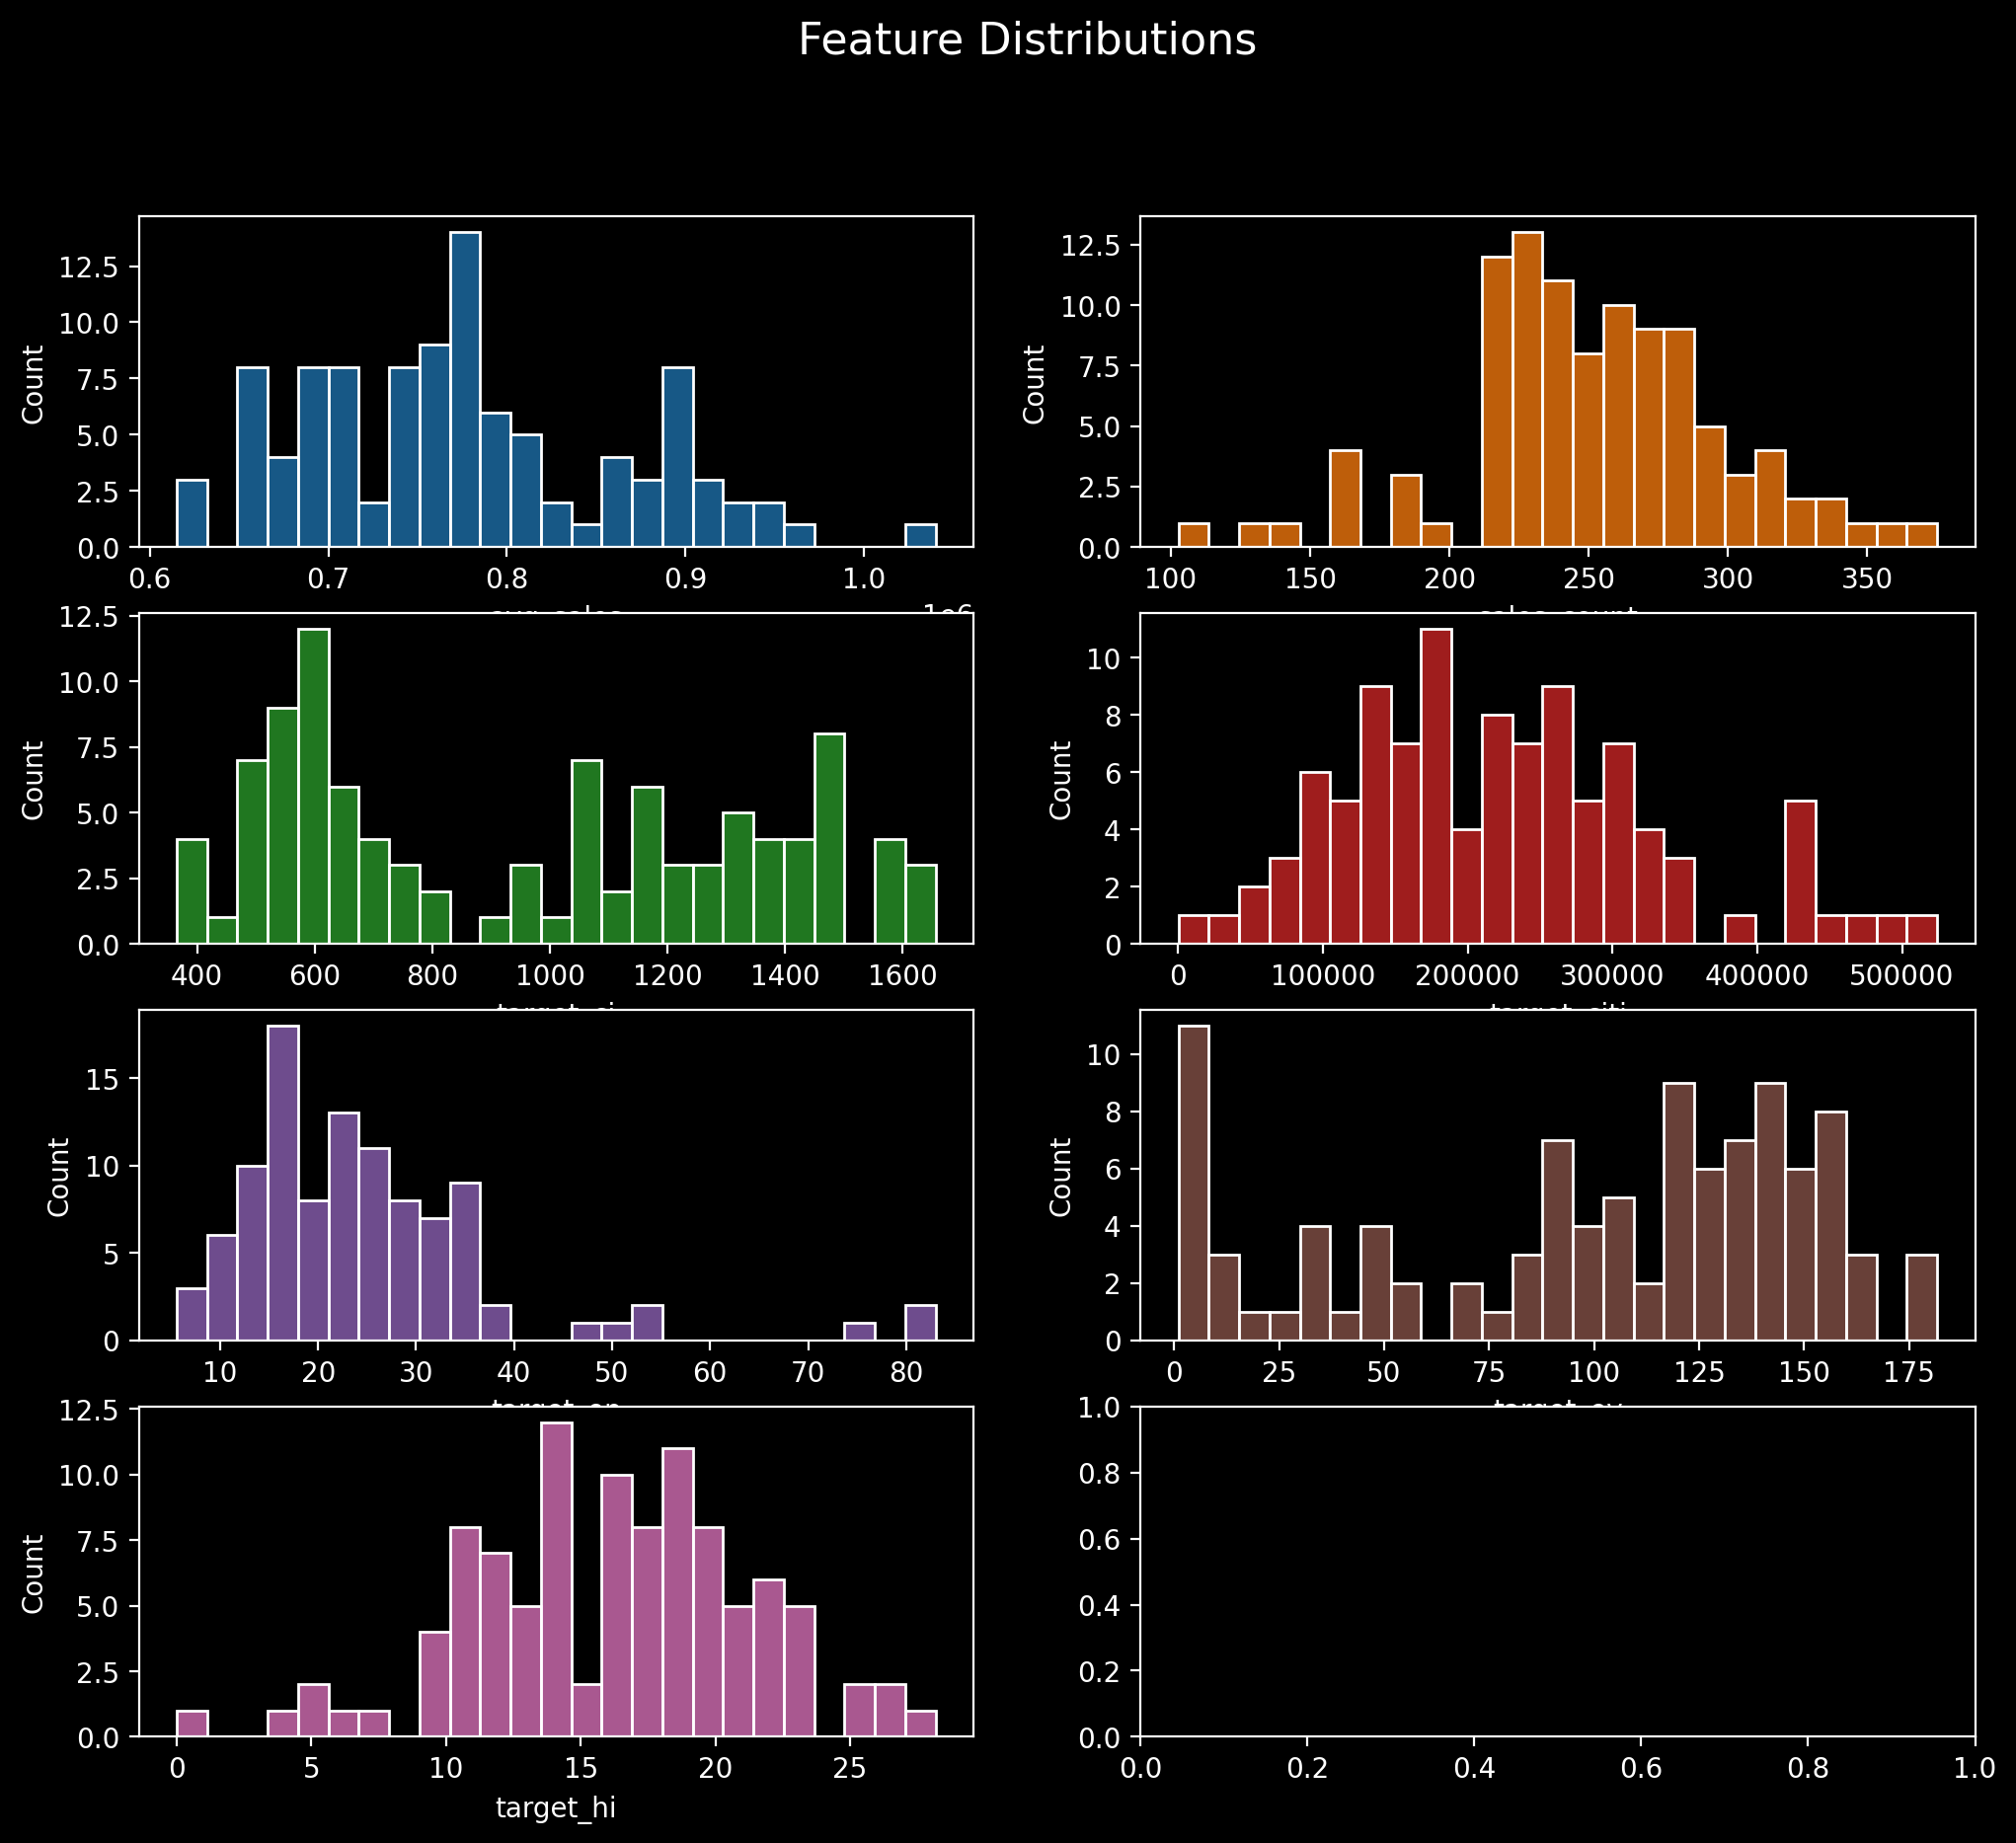

In [65]:

from utils.visualizations import df_colors, plot_all_time_series

row_len = math.ceil(len(df_all_monthly.columns)/2)
fig, ax = plt.subplots(figsize=(12,10), nrows=row_len, ncols=2)
fig.suptitle("Feature Distributions", fontsize=16)
for i, col in enumerate(list(df_all_monthly.columns)[:]):
    sns.histplot(df_all_monthly[col], ax=ax[i//2, i%2], color=df_colors[i], bins=25)
    
plt.show()

# Stationarity test

0
1
2
3
4
5
6
7


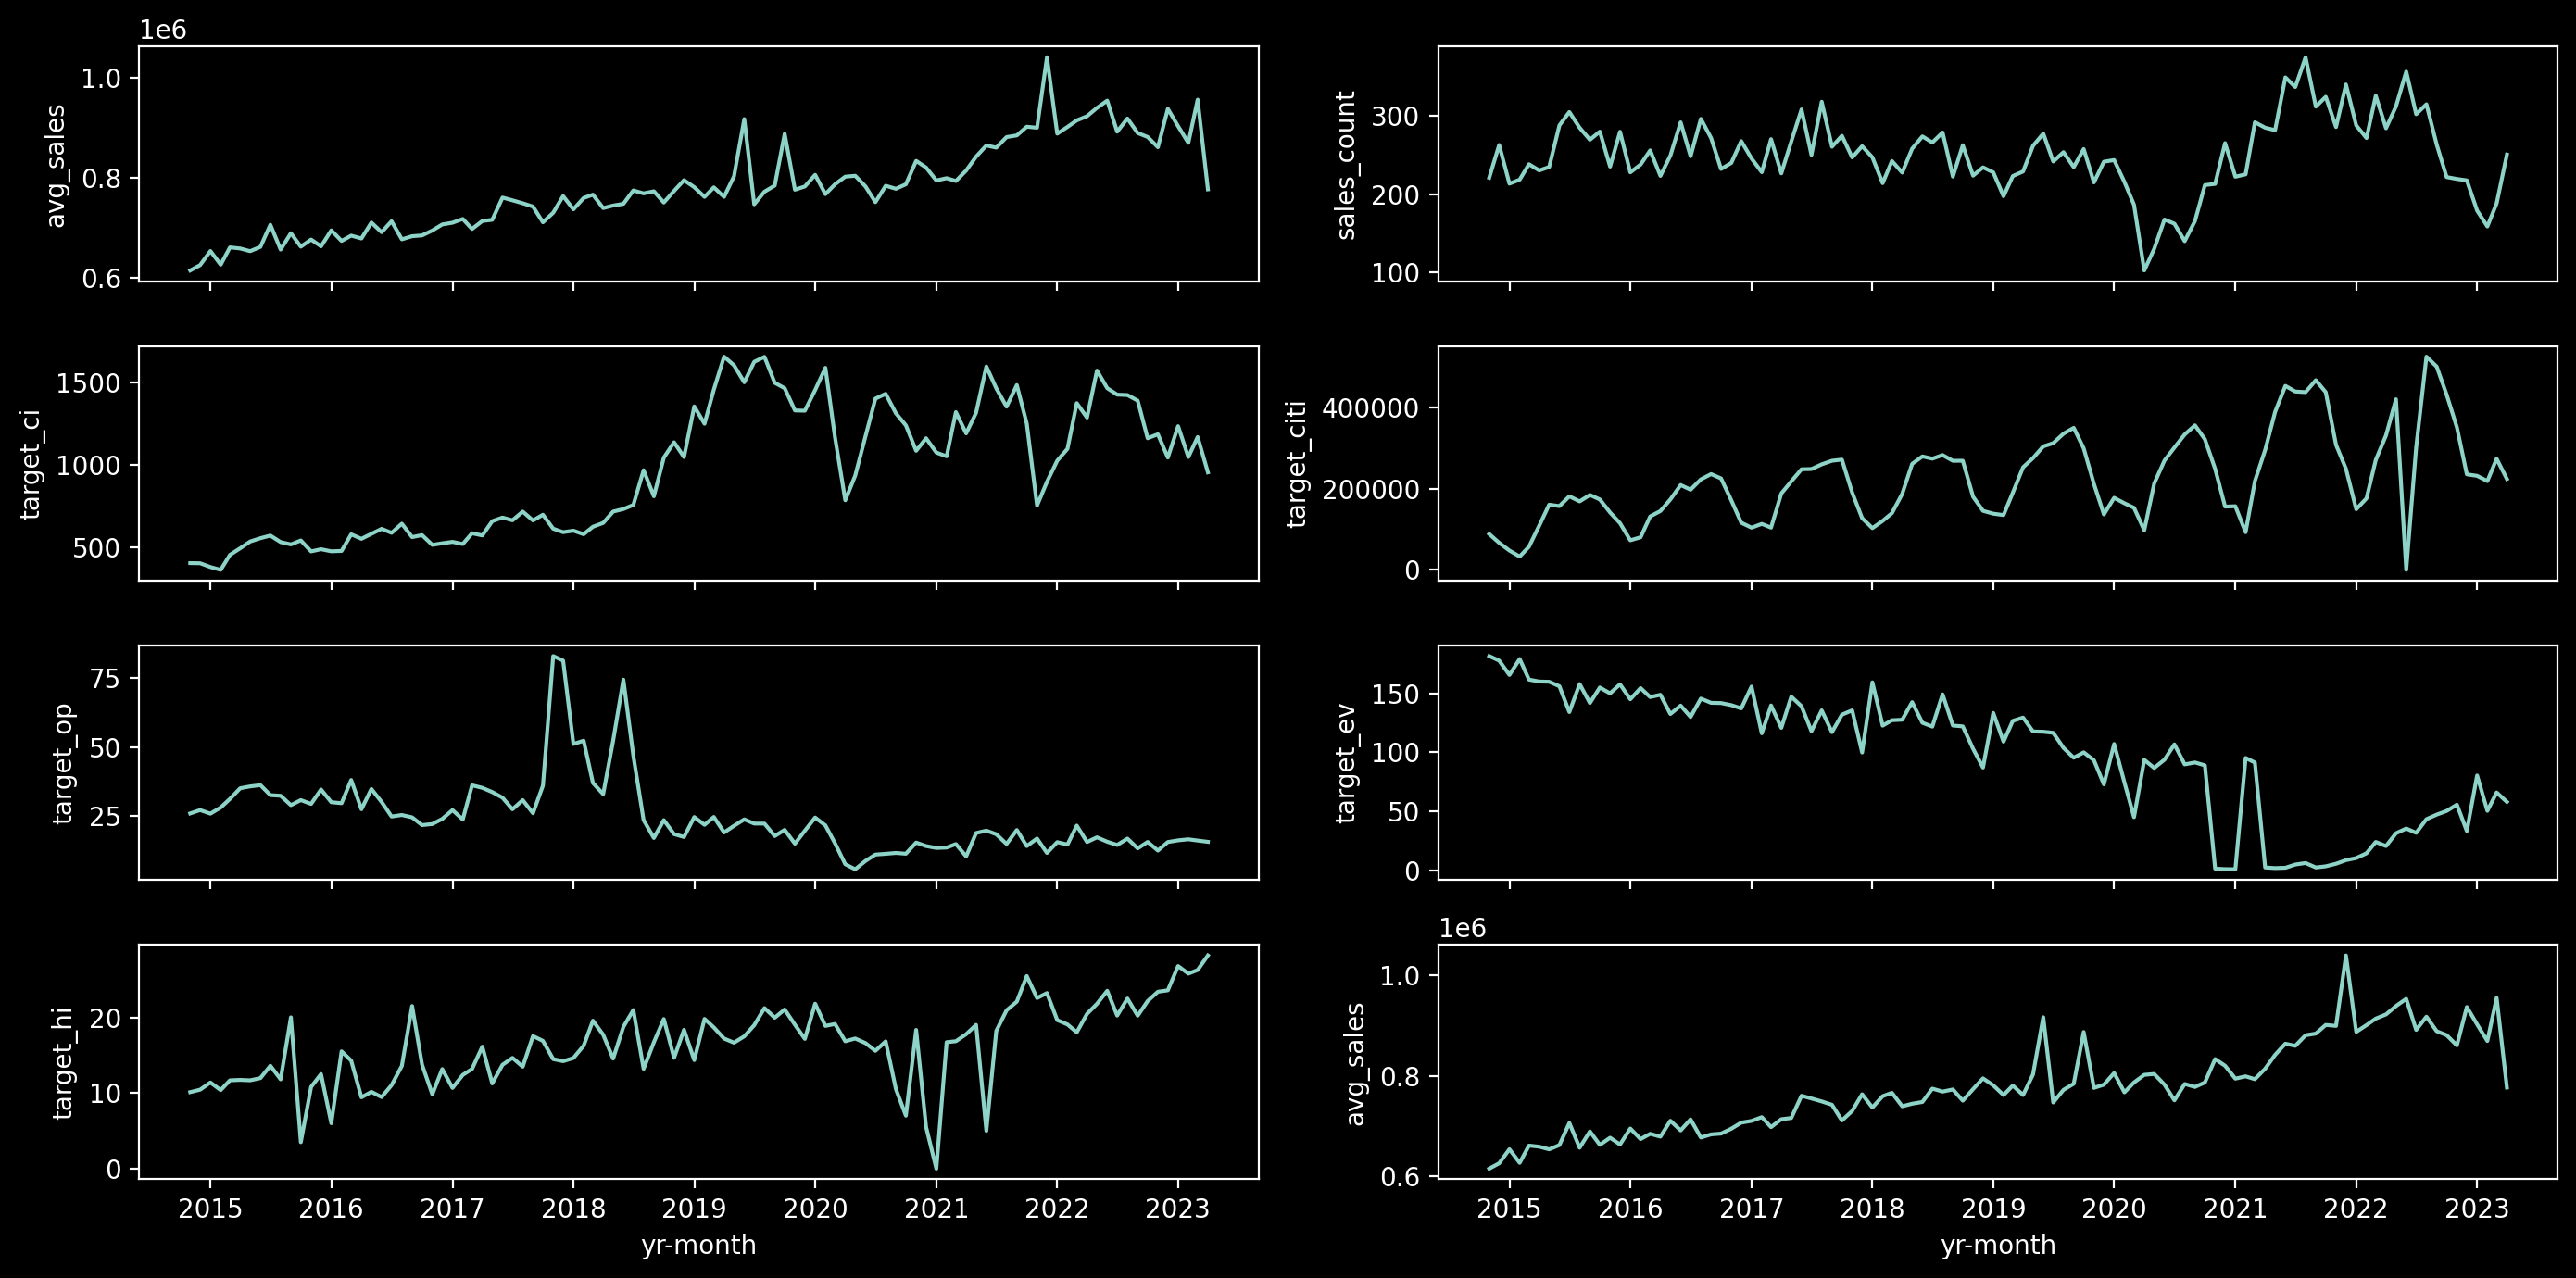

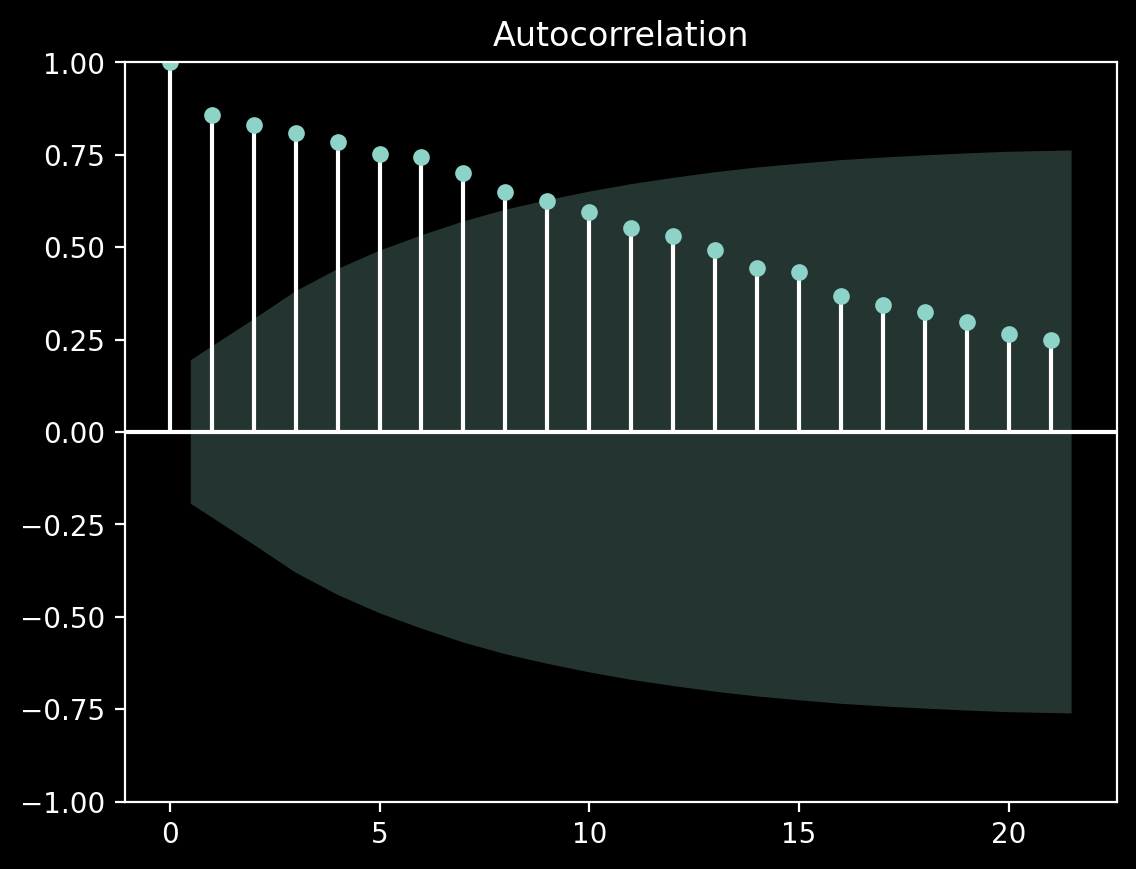

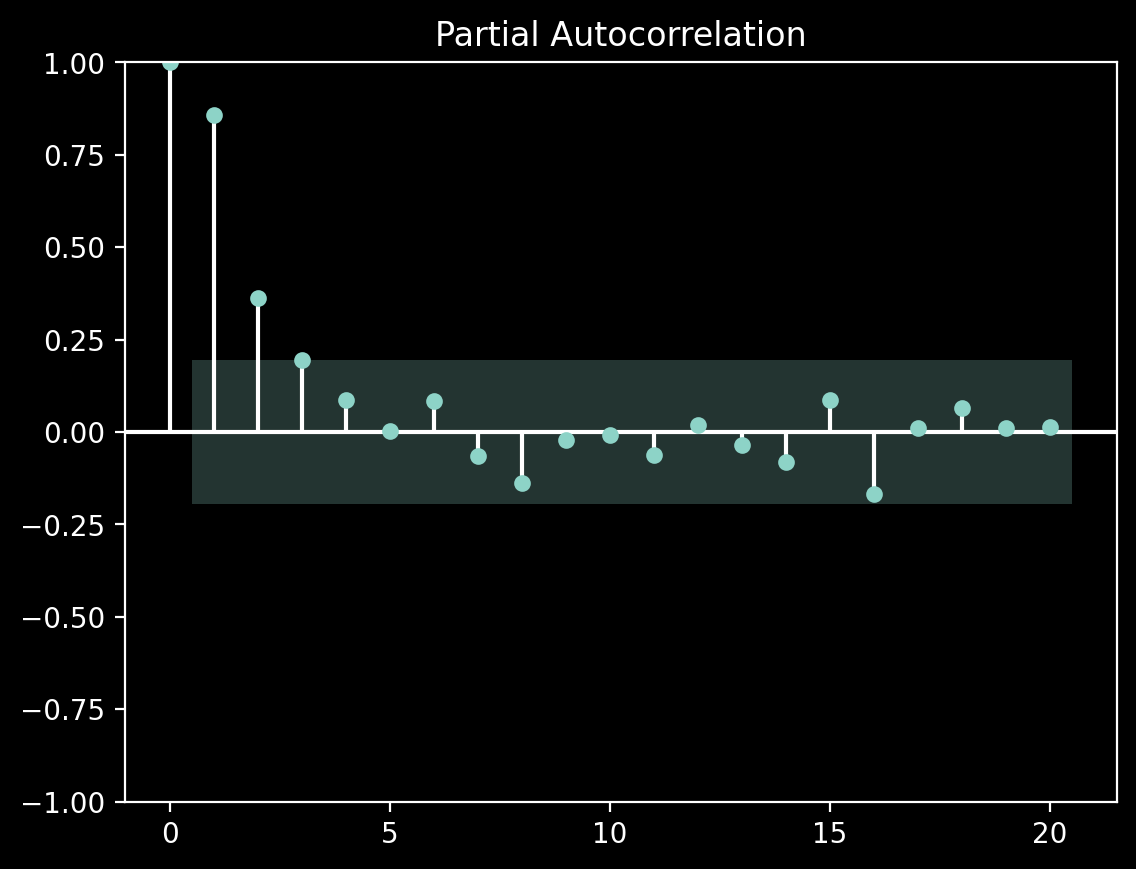

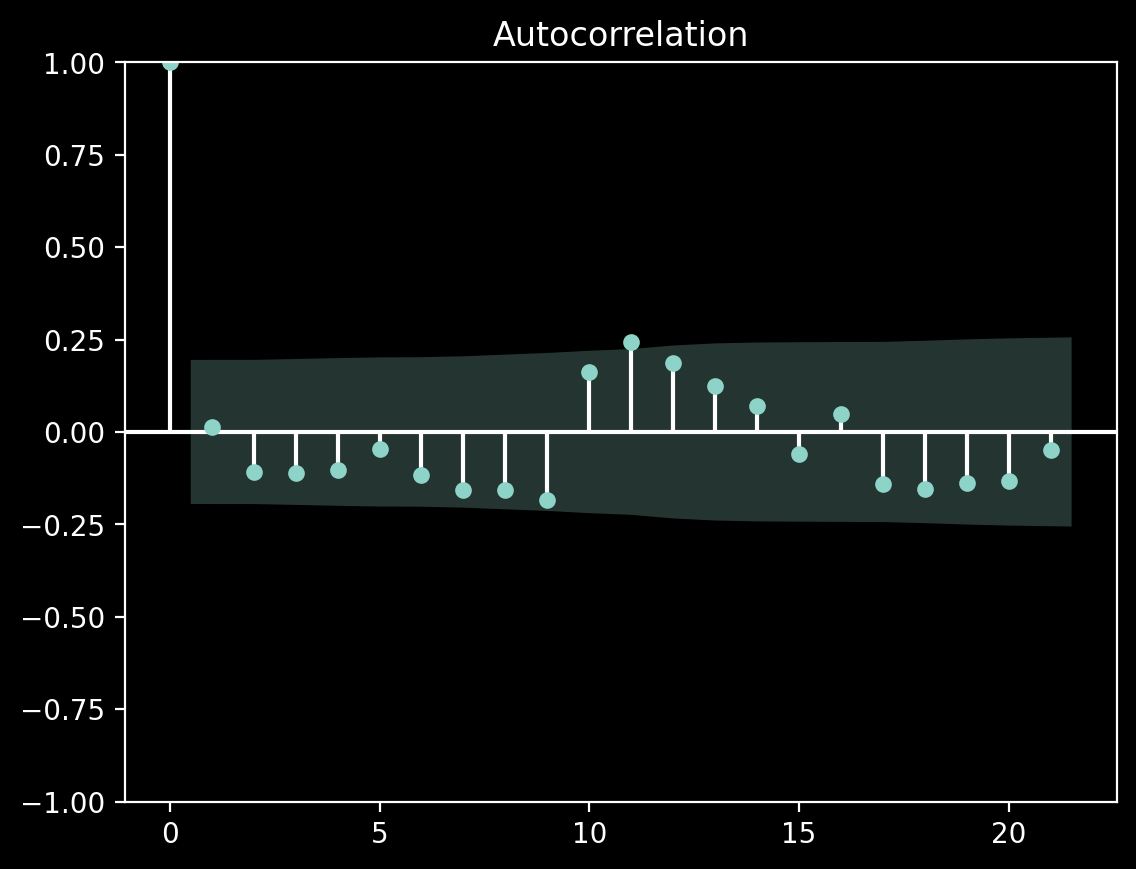

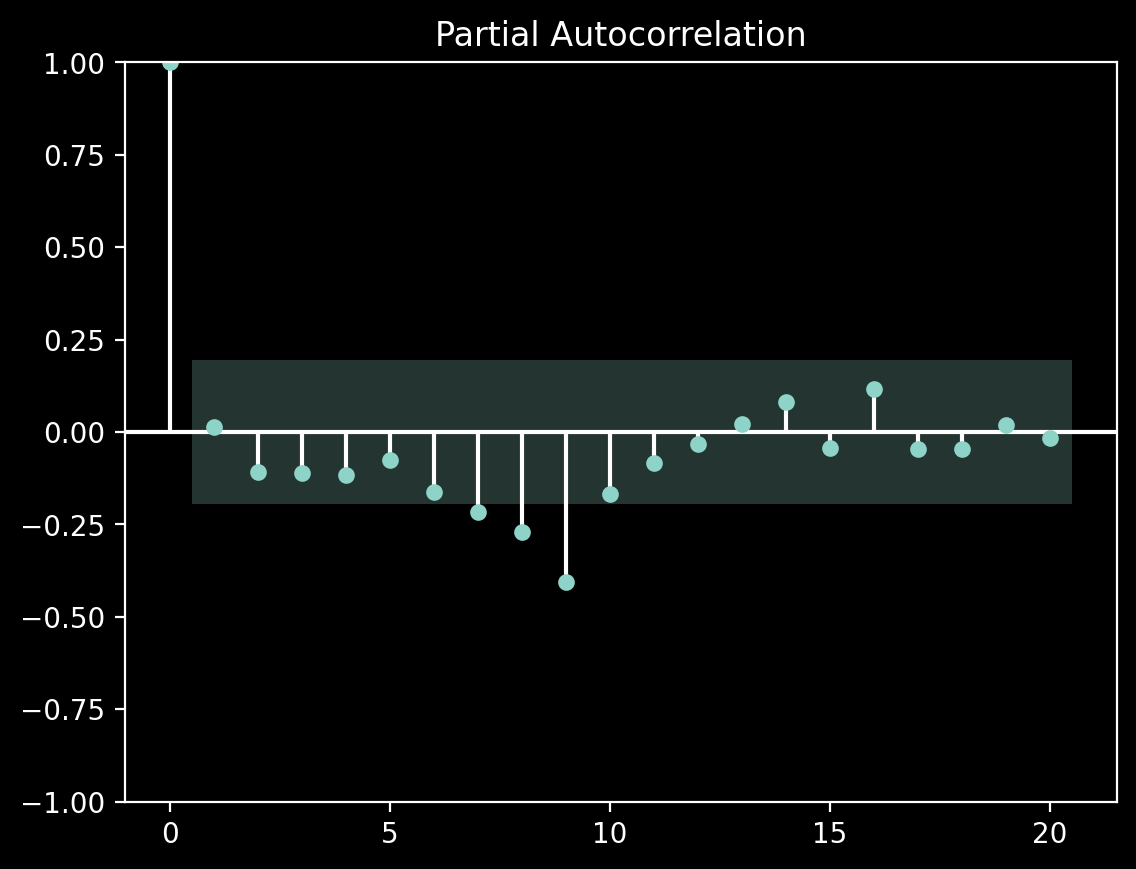

In [ ]:
data = df_all_monthly.copy()
df_plot = df_all_monthly.copy()
plt.style.use('dark_background')
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(ax.flatten()):
        print(i)
        sns.lineplot(data = data, x= data.index, y=list(data.columns)[i%7], ax=ax)

fig.tight_layout()
plt.show()

cols = list(data_differenced.columns)
data_differenced.columns

dataplot = data.copy().dropna()
series = dataplot[cols[0]]
plot_acf(series)
pyplot.show()
plot_pacf(series, lags=20)
pyplot.show()

idx = 1
data = data_differenced[['avg_sales', 'target_citi']]
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = data_differenced['target_citi']
plot_acf(series)
pyplot.show()
plot_pacf(series, lags=20)
pyplot.show()

In [ ]:
auto_corr = {}

for i, col in enumerate(list(df_all_monthly.columns)[1:]):
    auto_corr.update({col: [df_all_monthly[col].autocorr(i) for i in range(1,8)]})
    
    
pd.DataFrame.from_dict(auto_corr)

,sales_count,target_ci,target_citi,target_op,target_ev,target_hi
0,0.720653,0.935454,0.760382,0.806849,0.899829,0.594777
1,0.659018,0.880506,0.510090,0.594442,0.866587,0.516940
2,0.557502,0.832581,0.305530,0.508436,0.846331,0.577573
3,0.382522,0.785080,0.149601,0.475457,0.840382,0.401360
4,0.306161,0.756589,0.043251,0.486234,0.860788,0.508458
5,0.167504,0.735777,-0.034787,0.551912,0.833995,0.494454
6,0.064773,0.708302,-0.047149,0.537331,0.820516,0.372913


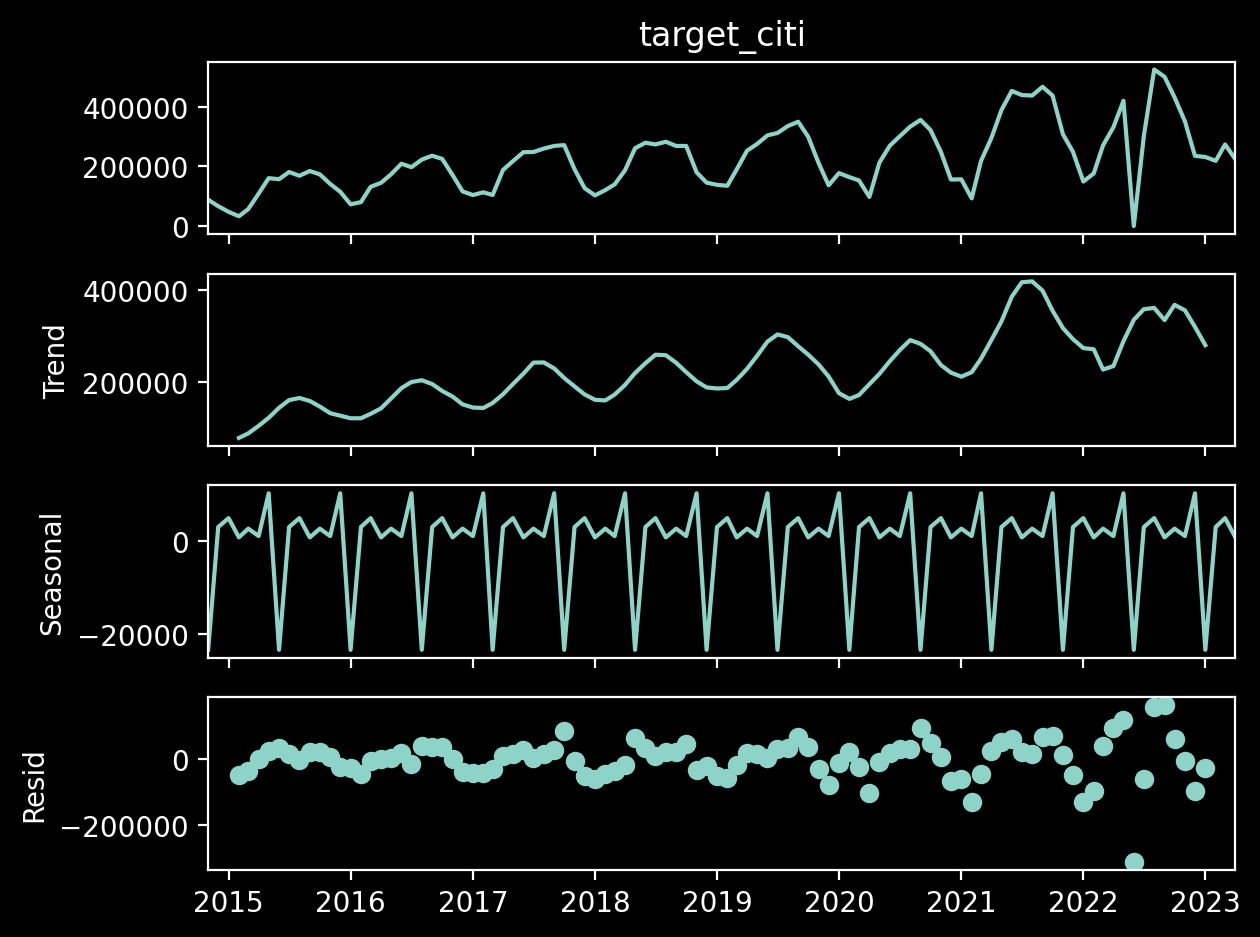

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df_all_monthly['target_citi'],model='additive', period=7)
decompose.plot();


In [66]:
import statsmodels.api as sm

data = data.copy()
# data = shifted.copy().dropna()

num_lags = 12

y = data['avg_sales'].copy()
results = {}
for i, col in enumerate(list(data.columns)[1:]):
    print(col)
    
    df_temp = data[[col, 'avg_sales']].copy()
    if col == 'target_ci':
       df_temp = df_temp[df_temp.index < '2021-07']
    elif col == 'target_ev':
         df_temp = df_temp[df_temp.index < '2020-02']



    granger_test = sm.tsa.stattools.grangercausalitytests(df_temp, maxlag=num_lags, verbose=False)
    
    results.update({col: [ granger_test[i][0]['ssr_ftest'][1] for i in range(1,num_lags)]})# if granger_test[i][0]['ssr_ftest'][1] < 0.05])
    
    causality_results = pd.DataFrame.from_dict(results, orient='index', columns=[f'lag_{i}' for i in range(1,num_lags)])
# highlihgt significaant values
#add title
inx = ['Sales Volume', 'Complaints',' Citibike', 'Operating Businesses','Evictions', 'Health Inspections']
causality_results.index = inx
#round to 3 decimal places
causality_results = causality_results.round(3)
print()
causality_results.style.apply(lambda x: ["background: red" if v < 0.05 else "" for v in x], axis = 1).set_caption('Granger Causality Test Results')



sales_count
target_ci
target_citi
target_op
target_ev
target_hi



,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
Sales Volume,0.961000,0.791000,0.837000,0.914000,0.743000,0.857000,0.843000,0.885000,0.624000,0.135000,0.108000
Complaints,0.005000,0.007000,0.049000,0.061000,0.004000,0.003000,0.002000,0.001000,0.001000,0.000000,0.001000
Citibike,0.095000,0.019000,0.008000,0.006000,0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Operating Businesses,0.024000,0.041000,0.152000,0.292000,0.640000,0.796000,0.823000,0.895000,0.795000,0.879000,0.867000
Evictions,0.001000,0.007000,0.027000,0.020000,0.056000,0.012000,0.043000,0.085000,0.282000,0.355000,0.410000
Health Inspections,0.000000,0.001000,0.011000,0.009000,0.093000,0.176000,0.271000,0.382000,0.430000,0.330000,0.113000


In [67]:
from statsmodels.tsa.stattools import adfuller

data = df_all_monthly.copy()  # .reset_index(drop=True)

def adfuller_test(series, sig=0.05, name=''):
    res = adfuller(series, autolag='AIC')
    p_value = round(res[1], 3)

    if p_value <= sig:
        print(f" {name} : P-Value = {p_value} => Stationary. ")
    else:
        print(f" {name} : P-Value = {p_value} => Non-stationary.")
    return res

print('Original Data')
for name, column in data.items():
    adfuller_test(column, name=column.name)

print('Differenced Data')
data_differenced = data.diff().dropna()
for name, column in data_differenced.items():
    adfuller_test(column, name=column.name)

data_differenced['sales_count'] = data['sales_count'].iloc[1:]

Original Data
 avg_sales : P-Value = 0.695 => Non-stationary.
 sales_count : P-Value = 0.041 => Stationary. 
 target_ci : P-Value = 0.244 => Non-stationary.
 target_citi : P-Value = 0.606 => Non-stationary.
 target_op : P-Value = 0.359 => Non-stationary.
 target_ev : P-Value = 0.642 => Non-stationary.
 target_hi : P-Value = 0.754 => Non-stationary.
Differenced Data
 avg_sales : P-Value = 0.0 => Stationary. 
 sales_count : P-Value = 0.088 => Non-stationary.
 target_ci : P-Value = 0.0 => Stationary. 
 target_citi : P-Value = 0.0 => Stationary. 
 target_op : P-Value = 0.0 => Stationary. 
 target_ev : P-Value = 0.0 => Stationary. 
 target_hi : P-Value = 0.0 => Stationary. 


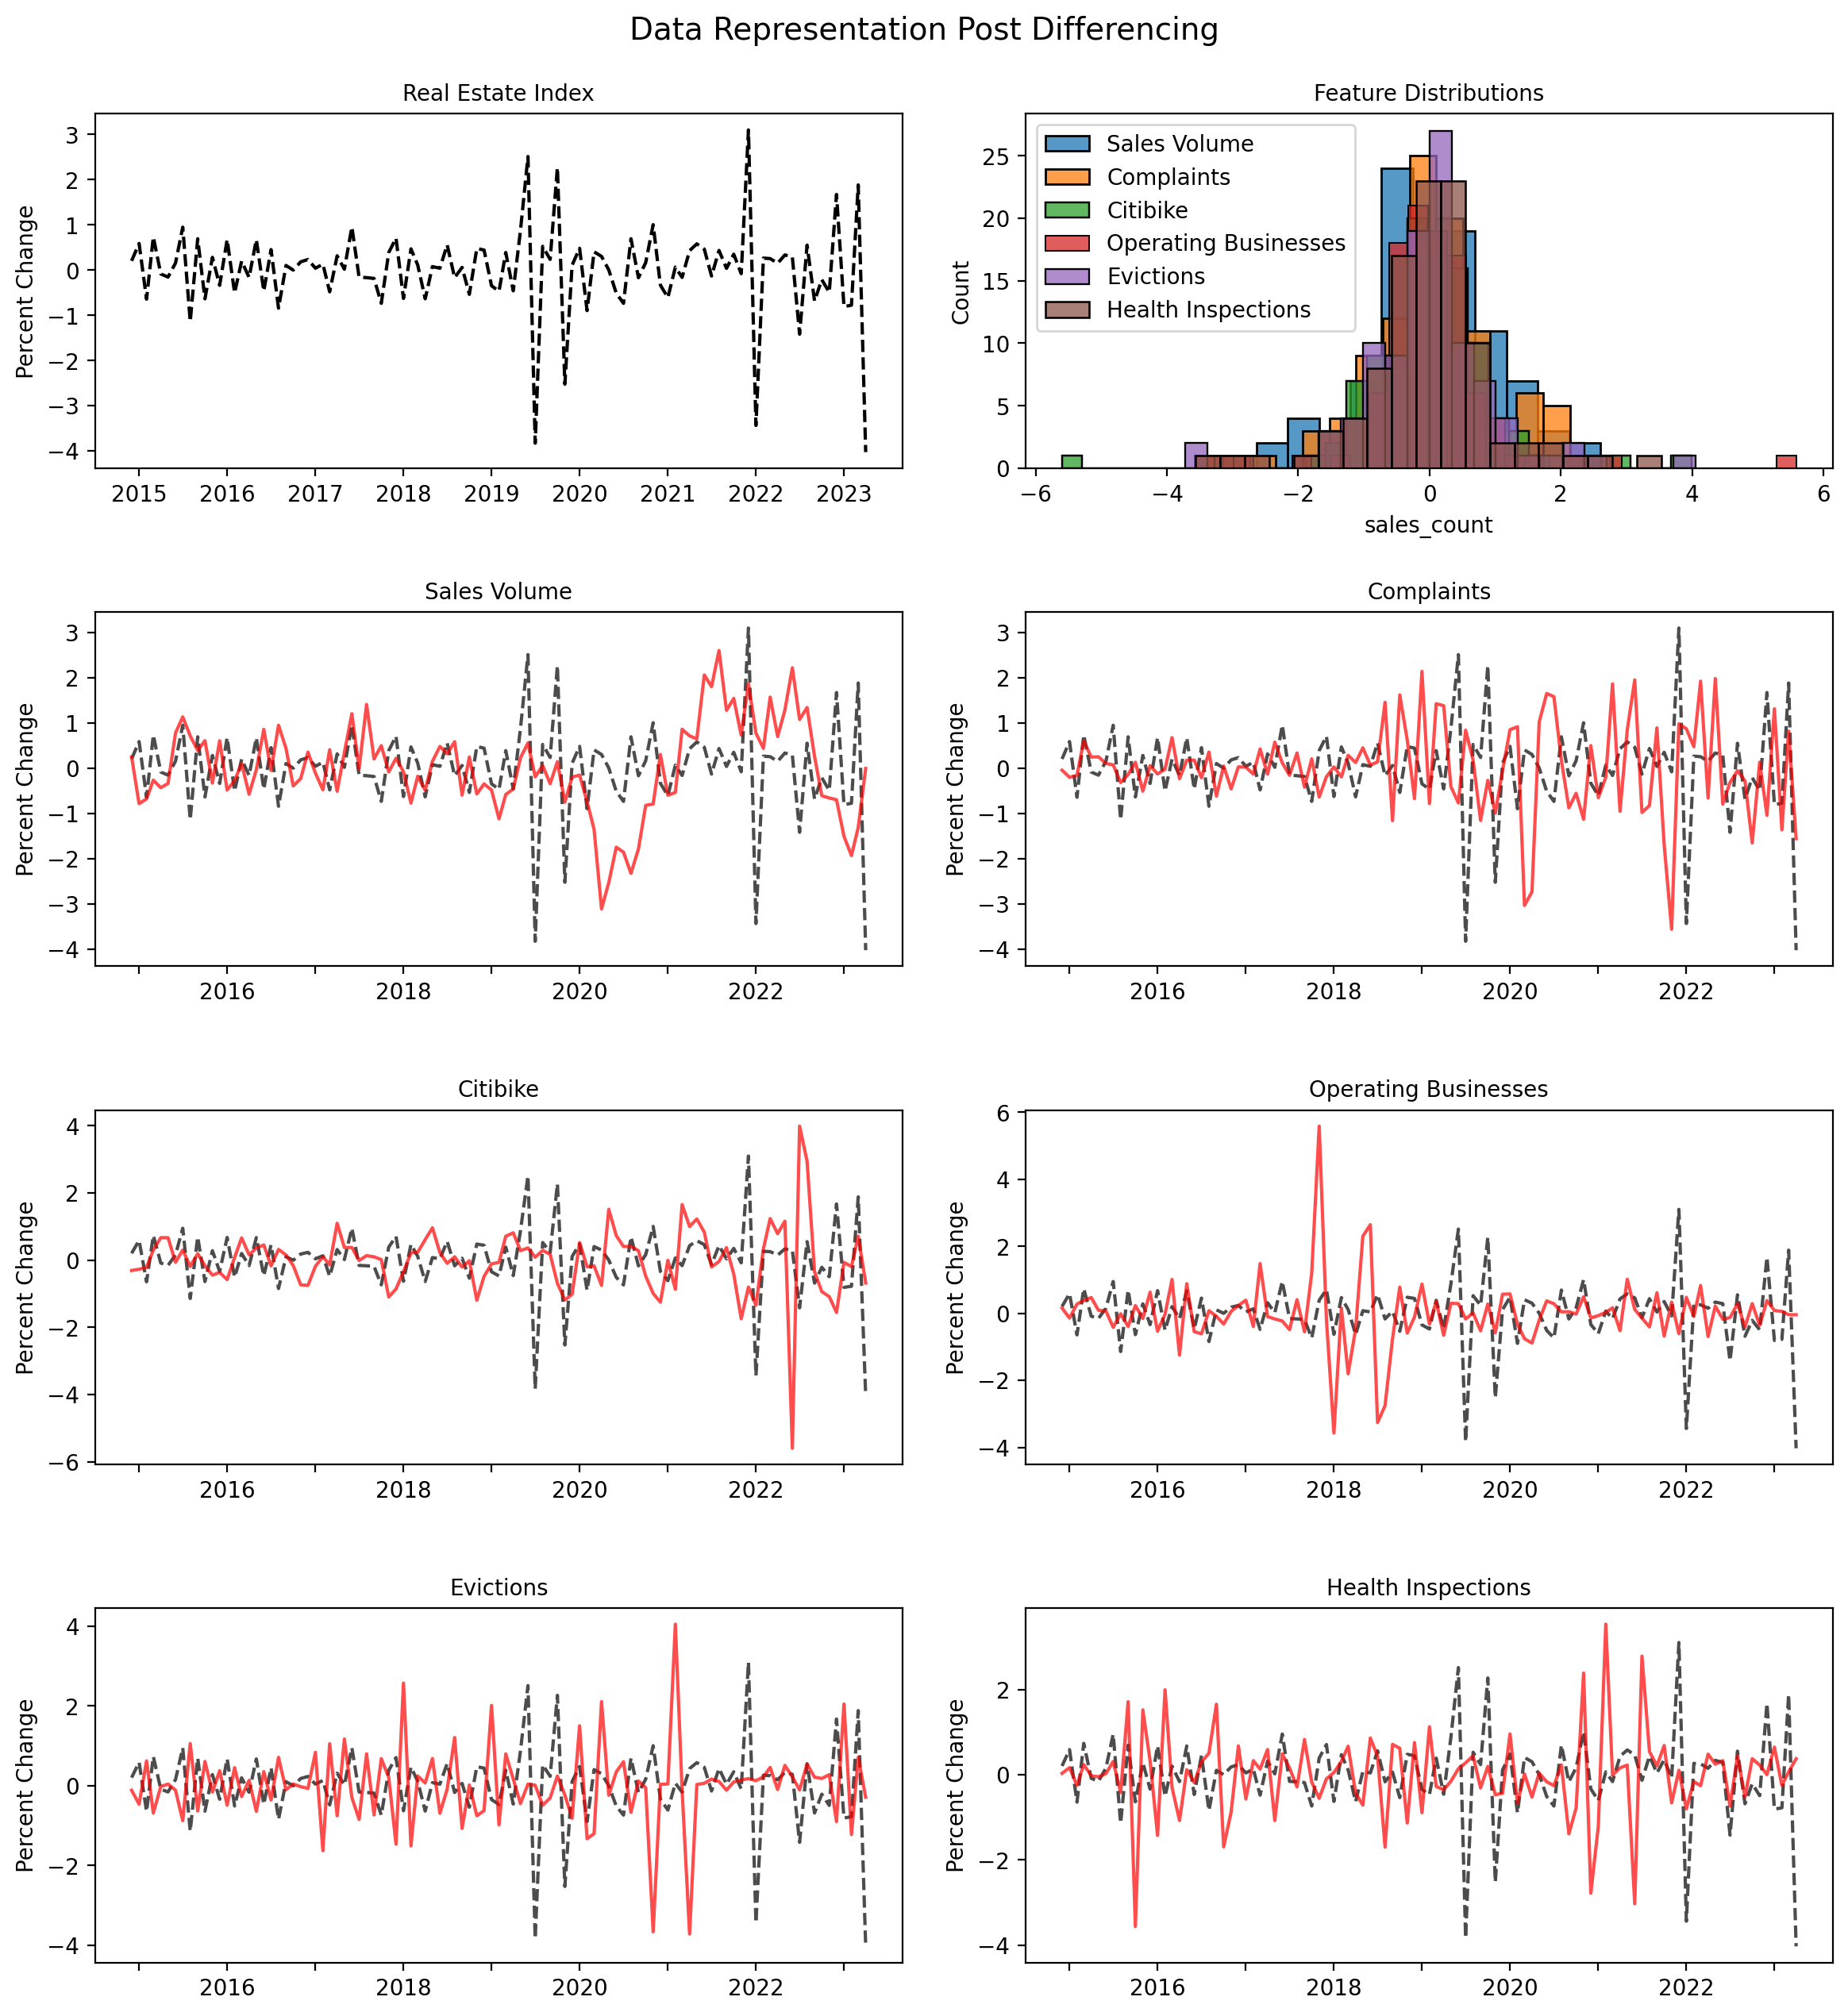

In [68]:
with plt.style.context('default'):
    fig = plot_all_time_series((data_differenced), 'Data Representation Post Differencing', for_ieee=True)

## Identify optimal feature lags for predicting real estate index 

In [9]:
best_shifts = analysis.optimize_shifts(df_all_monthly, shifts, analysis.train_model, analysis.evaluate_model)
print(best_shifts)

MSE: 2412841783.3503594
MAE: 35747.4068627451
R2: 0.7366170663869565
MSE: 2412841783.3503594
MAE: 35747.4068627451
R2: 0.7366170663869565

MSE: 1118227988.8648353
MAE: 25924.708088235297
R2: 0.8341271280244915
MSE: 1118227988.8648353
MAE: 25924.708088235297
R2: 0.8341271280244915
...
MSE: 1118227988.8648353


Best Shift {'target_ci': 3, 'target_citi': 6, 'target_op': 2, 'target_ev': 7, 'target_hi': 1} 


## Shift the data based on the best shifts

In [105]:
data = df_all_monthly.copy()
shifts = { # From `best_shifts`
    "target_ci": 3,
    "target_citi": 6,
    "target_op": 2,
    "target_ev": 7,
    "target_hi": 1,
}
for col, shift in shifts.items():
    data[col] = data[col].shift(shift)
shifted = data.copy()
shifted_corr = shifted.corr().iloc[0]

unshifted_corr = df_all_monthly.corr().iloc[0]
corr_df = pd.DataFrame({ 'Unshifted': unshifted_corr, 'Shifted': shifted_corr,})

# add third column to show the difference
corr_df = corr_df.drop(['avg_sales', 'sales_count'])
corr_df['Difference'] = corr_df['Shifted'] - corr_df['Unshifted']
corr_df

,Unshifted,Shifted,Difference
target_ci,0.702,0.732,0.030
target_citi,0.564,0.550,-0.015
target_op,-0.446,-0.428,0.019
target_ev,-0.845,-0.855,-0.010
target_hi,0.631,0.594,-0.038


## XGBoost Modeling
note: compare unshifted vs shifted of alt data on forecasting real estate idx using xgboost

## Train model predicting real estate index using unshifted alt features


MAE: 39312.609
MAPE: 4.726
R2: 0.722


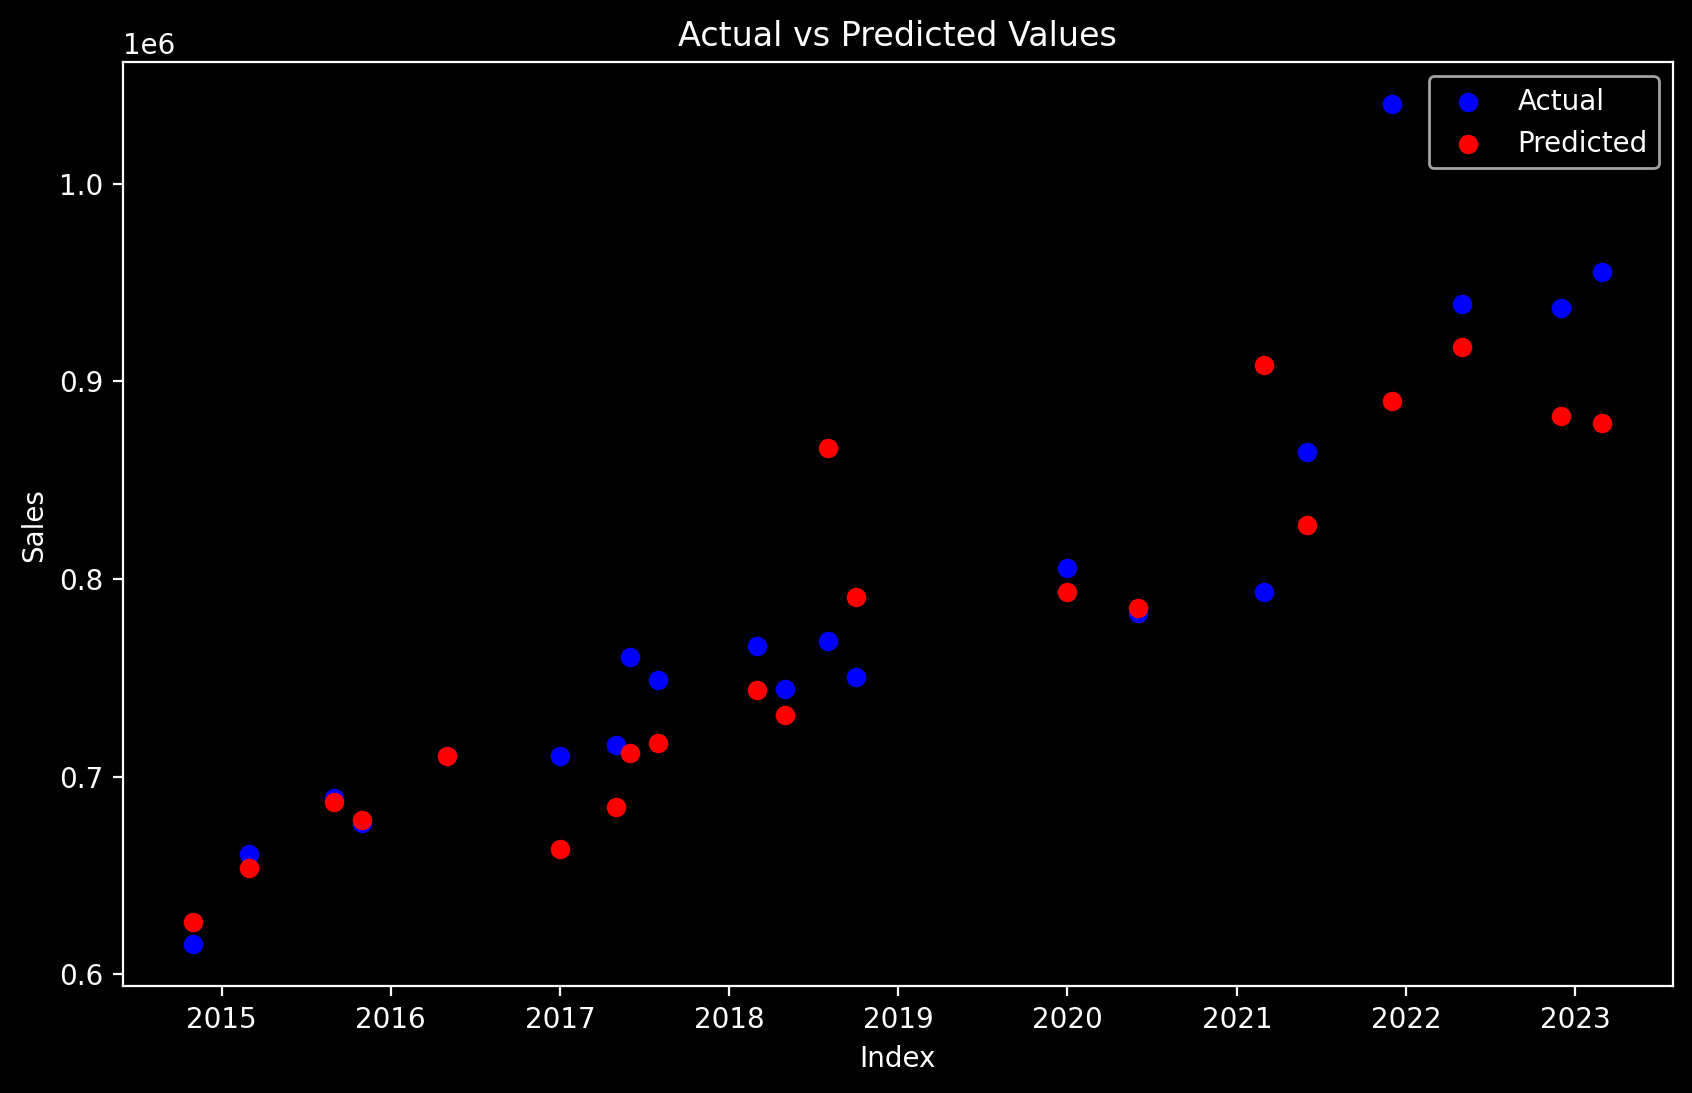

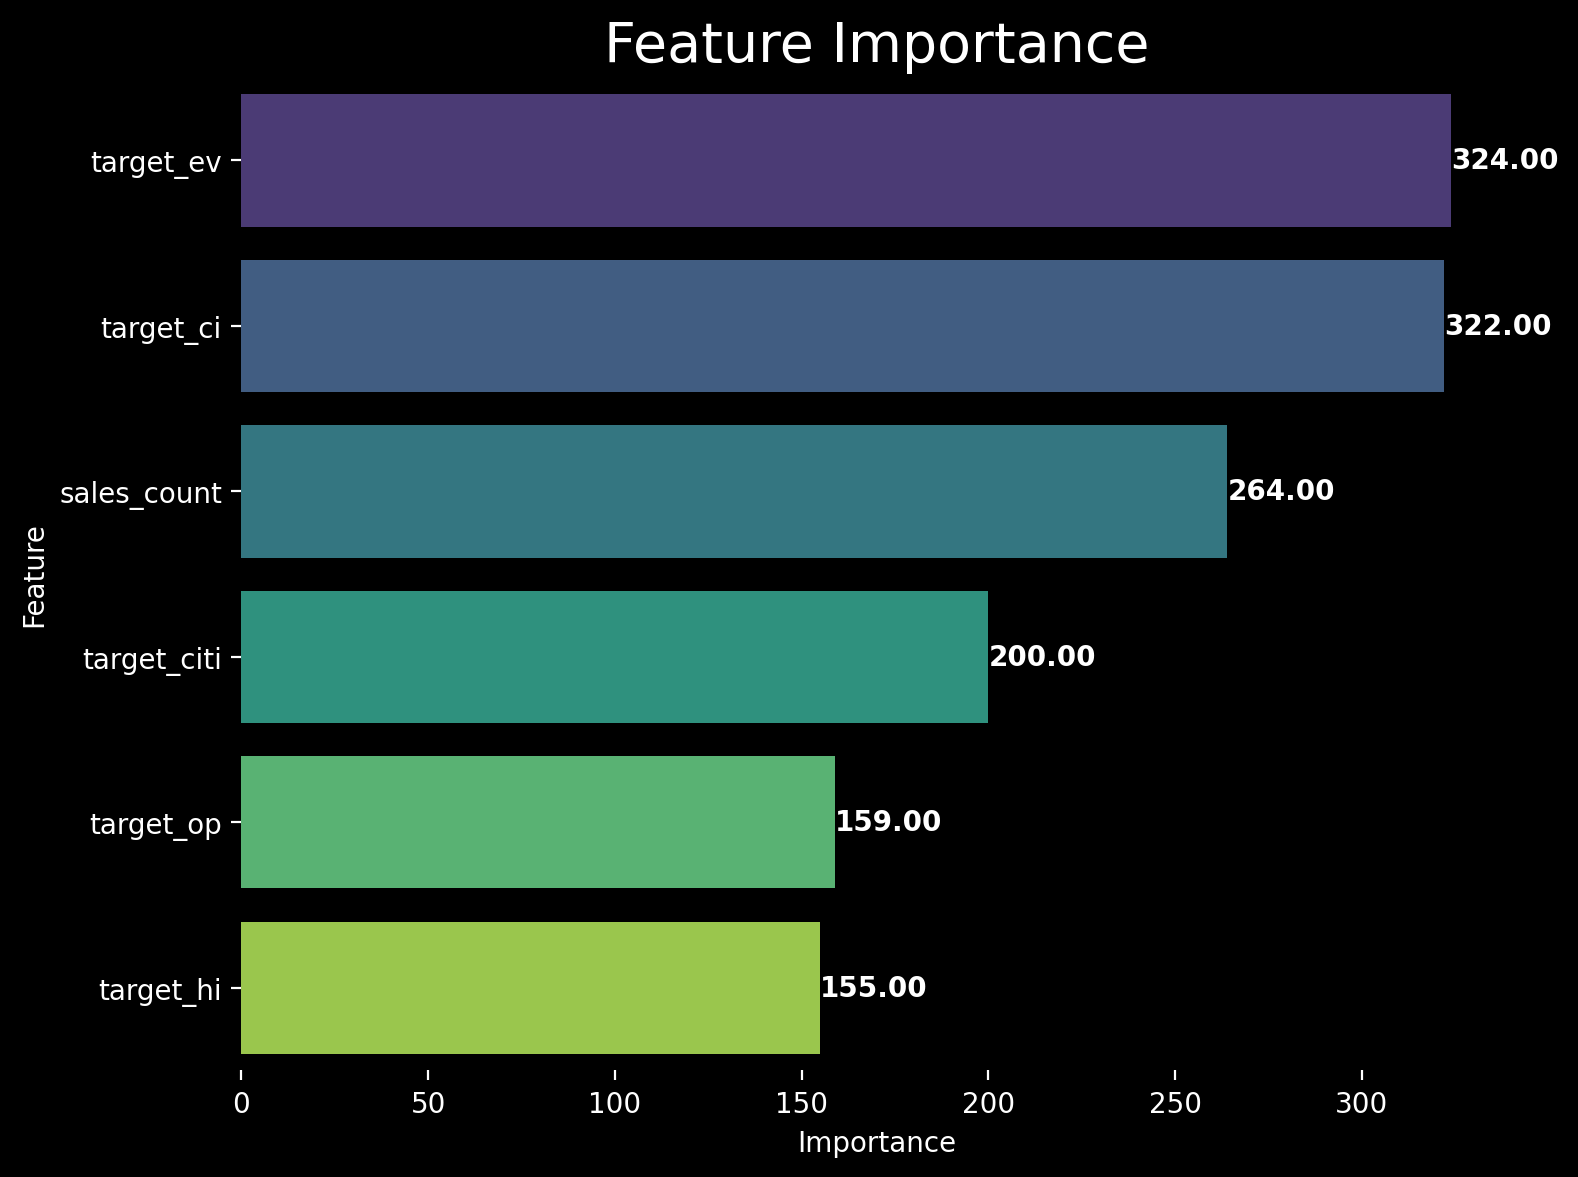

In [94]:
data = df_all_monthly.copy()

X_test, y_test, y_pred, model = analysis.train_model(data)
mse, mae, r2 = analysis.evaluate_model(y_test, y_pred)

analysis.plot_data(X_test, y_test, y_pred)
analysis.plot_importance_enhanced(model)
analysis.feature_importances(model);

## Train model predicting real estate index using shifted alt features


MAE: 19804.304
MAPE: 2.453
R2: 0.898


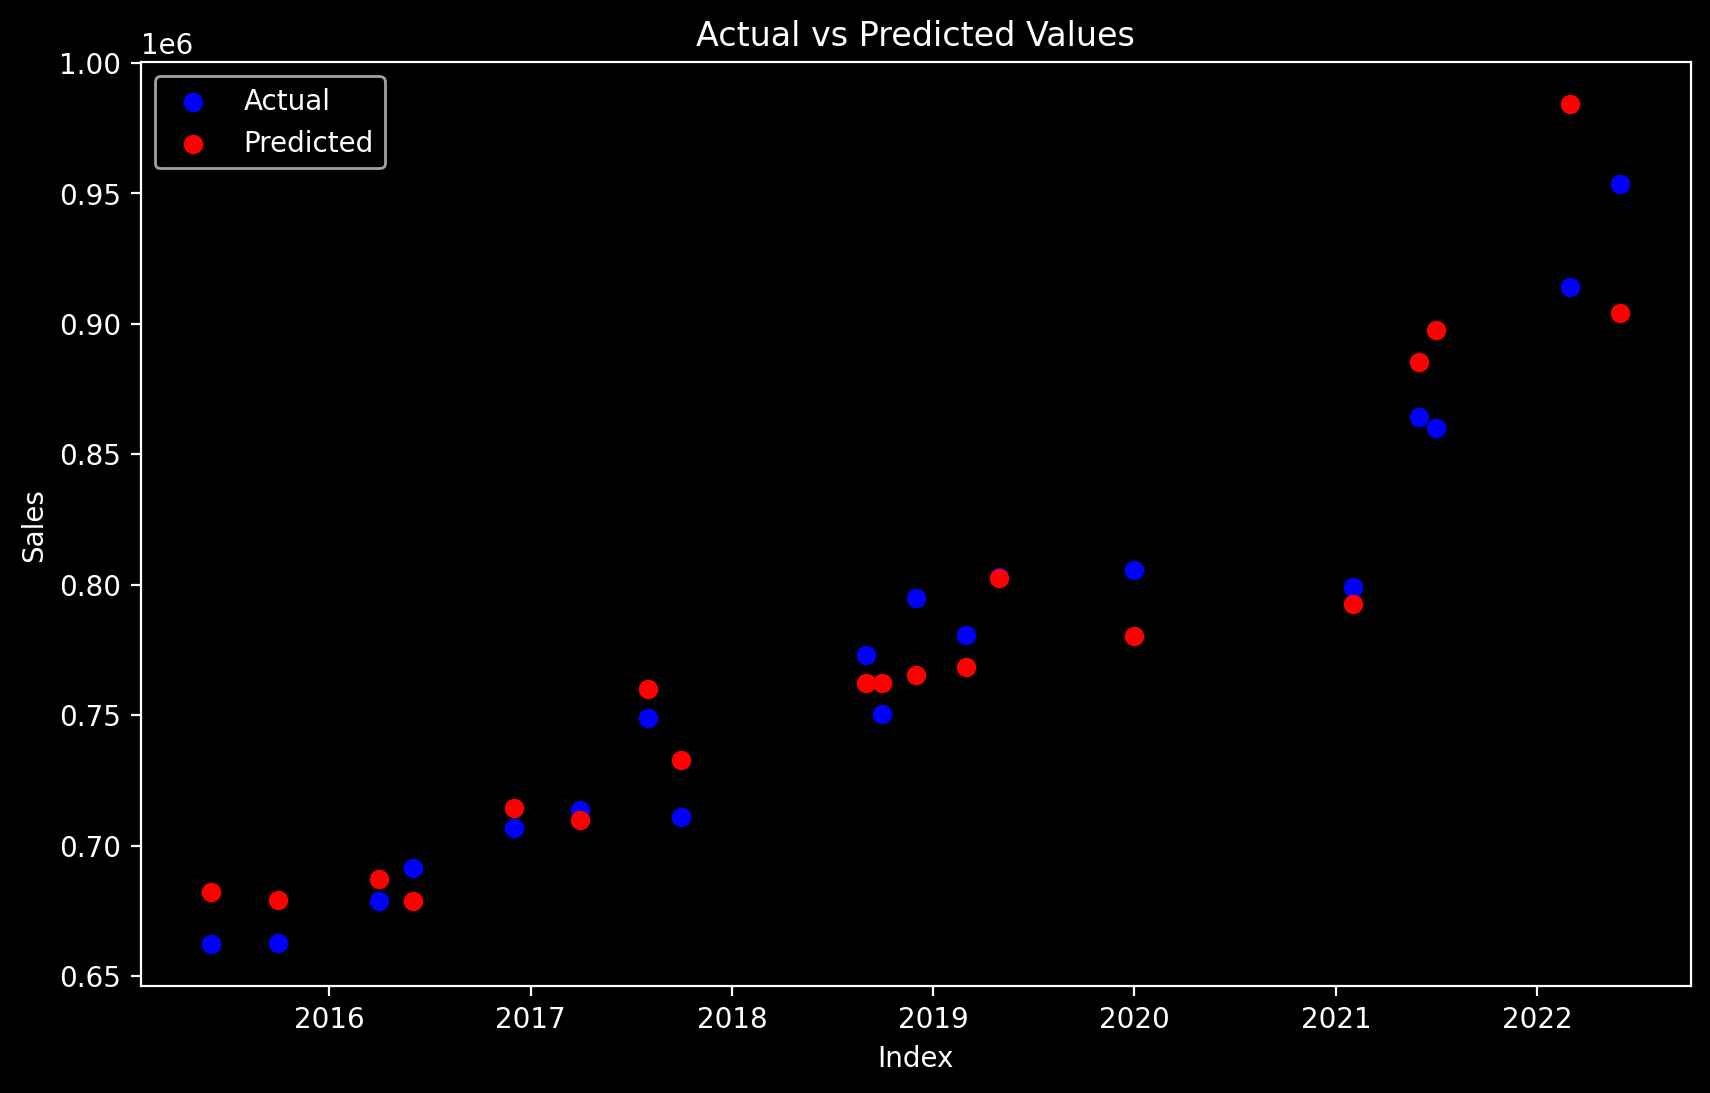

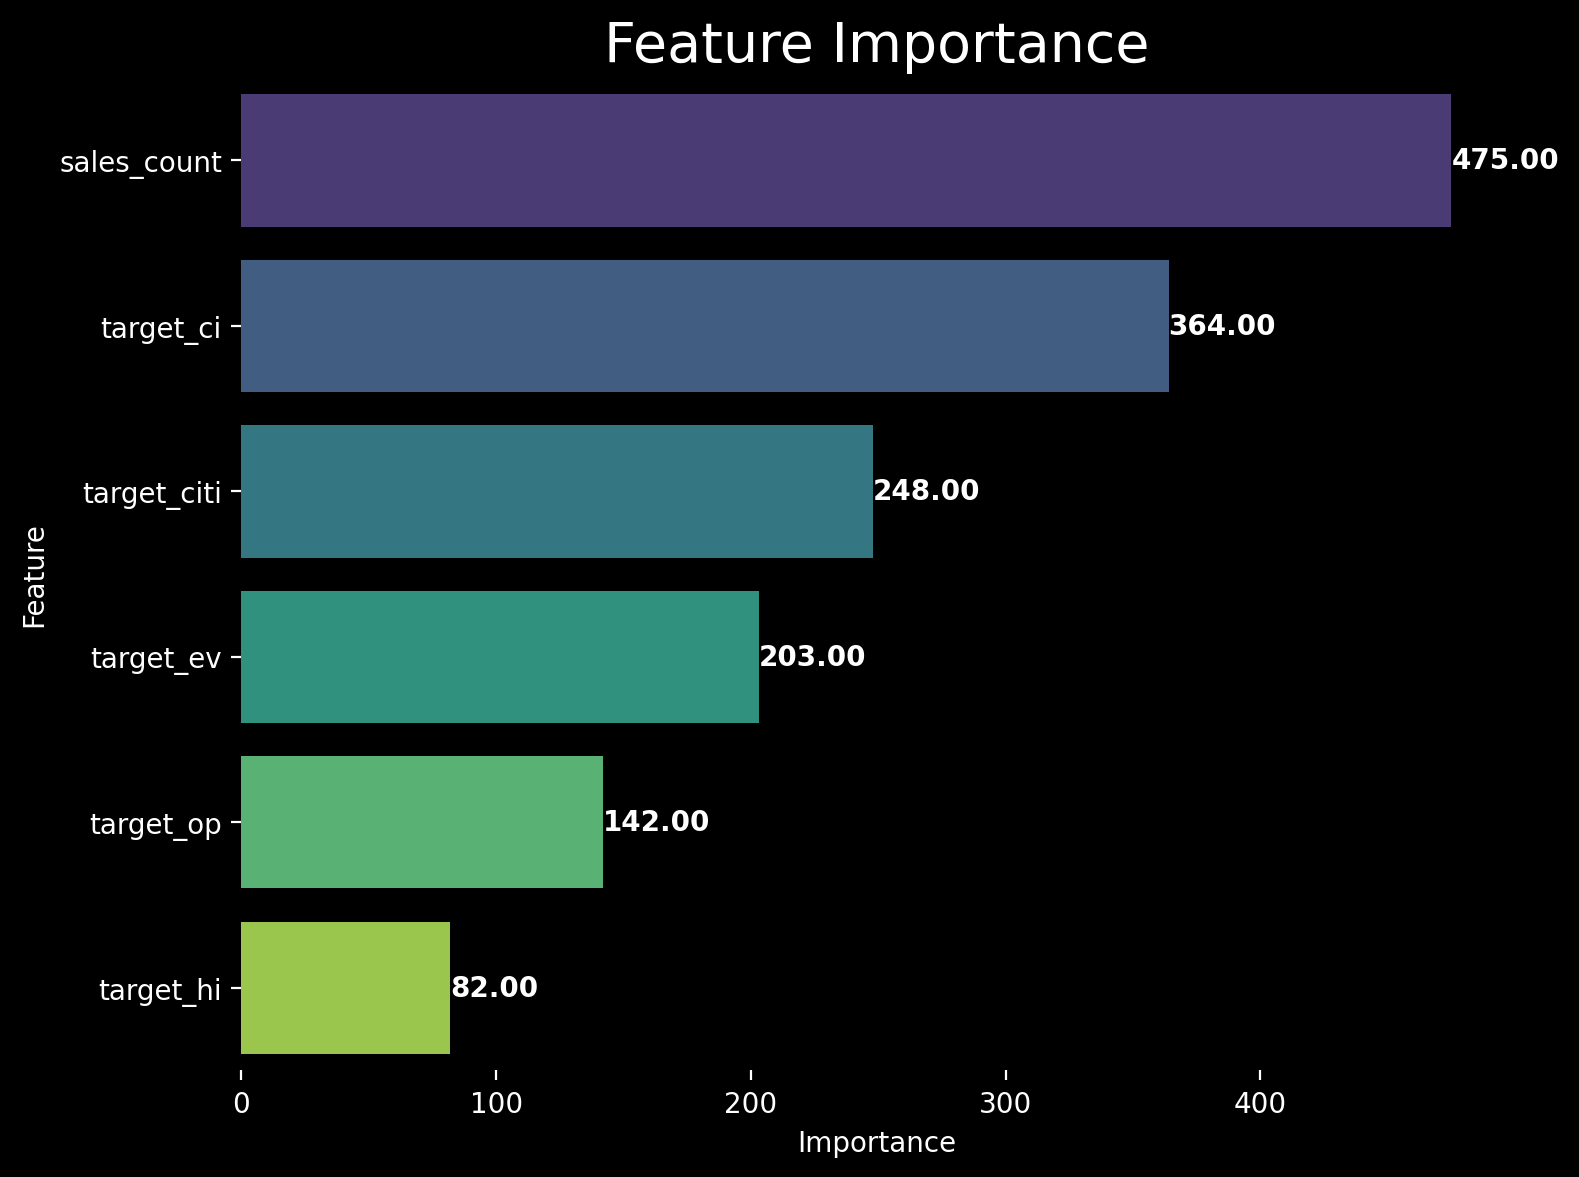

In [93]:
data = shifted.dropna()
X_test, y_test, y_pred, model = analysis.train_model(data)
analysis.evaluate_model(y_test, y_pred)
analysis.plot_data(X_test, y_test, y_pred)
analysis.plot_importance_enhanced(model)
analysis.feature_importances(model)


## Results

### Optimal Shifts
```python
shifts = {
    "target_ci": 3,
    "target_citi": 6,
    "target_op": 2,
    "target_ev": 7,
    "target_hi": 1,
}
```

### Unshifted
```
MAE: 39312.609
MAPE: 4.726
R2: 0.722
```

### Shifted 
```
MAE: 19804.304
MAPE: 2.453
R2: 0.898
```

lets goooooooo